<a href="https://colab.research.google.com/github/abhiyantaabhishek/time_series_forecast_using_transformer/blob/master/transformer_multistep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/abhiyantaabhishek/time_series_forecast_using_transformer

Cloning into 'time_series_forecast_using_transformer'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [2]:
%cd time_series_forecast_using_transformer

/content/time_series_forecast_using_transformer


In [3]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
from matplotlib import pyplot
import os

torch.manual_seed(0)
np.random.seed(0)

In [4]:
input_window = 100
output_window = 5
batch_size = 10 # batch size
device = torch.device("cuda" )
print(torch.cuda.get_device_name(0))

Tesla T4


In [5]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [6]:
class TransAm(nn.Module):
    def __init__(self,feature_size=250,num_layers=1,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


In [7]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = np.append(input_data[i:i+tw][:-output_window] , output_window * [0])
        train_label = input_data[i:i+tw]
        #train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

In [8]:
def get_data():
    time        = np.arange(0, 400, 0.1)
    amplitude   = np.sin(time) + np.sin(time*0.05) +np.sin(time*0.12) *np.random.normal(-0.2, 0.2, len(time))
    
    #from pandas import read_csv
    #series = read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
    
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #amplitude = scaler.fit_transform(series.to_numpy().reshape(-1, 1)).reshape(-1)
    amplitude = scaler.fit_transform(amplitude.reshape(-1, 1)).reshape(-1)
    
    
    sampels = 2800
    train_data = amplitude[:sampels]
    test_data = amplitude[sampels:]

    # convert our train data into a pytorch train tensor
    #train_tensor = torch.FloatTensor(train_data).view(-1)
    # todo: add comment.. 
    train_sequence = create_inout_sequences(train_data,input_window)
    train_sequence = train_sequence[:-output_window] #todo: fix hack?

    #test_data = torch.FloatTensor(test_data).view(-1) 
    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window] #todo: fix hack?

    return train_sequence.to(device),test_data.to(device)

In [9]:
def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
    return input, target

In [10]:
def train(train_data):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)        
        #loss = criterion(output[-output_window:], targets[-output_window:])
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

In [11]:
def plot_and_loss(eval_model, data_source,epoch):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i,1)
            # look like the model returns static values for the output window
            output = eval_model(data)                    
            #total_loss += criterion(output[-output_window:], target[-output_window:]).item()
            total_loss += criterion(output, target).item()
            test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
            
    #test_result = test_result.cpu().numpy()
    len(test_result)

    pyplot.plot(test_result,color="red")
    pyplot.plot(truth[:500],color="blue")
    pyplot.plot(test_result-truth,color="green")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    os.makedirs('graph',exist_ok=True)
    pyplot.savefig('graph/transformer-epoch%d.png'%epoch)
    pyplot.close()
    
    return total_loss / i

In [12]:

def predict_future(eval_model, data_source,steps):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    _ , data = get_batch(data_source, 0,1)
    with torch.no_grad():
        for i in range(0, steps,1):
            input = torch.clone(data[-input_window:])
            input[-output_window:] = 0     
            output = eval_model(data[-input_window:])                        
            data = torch.cat((data, output[-1:]))
            
    data = data.cpu().view(-1)
    

    pyplot.plot(data,color="red")       
    pyplot.plot(data[:input_window],color="blue")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    os.makedirs('graph',exist_ok=True)
    pyplot.savefig('graph/transformer-future%d.png'%steps)
    pyplot.close()

In [13]:
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)            
            #total_loss += len(data[0])* criterion(output[-output_window:], targets[-output_window:]).cpu().item()
            total_loss += len(data[0])* criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

In [14]:
train_data, val_data = get_data()

In [15]:
train_data.shape

torch.Size([2695, 2, 100])

In [16]:
import matplotlib.pyplot as plt


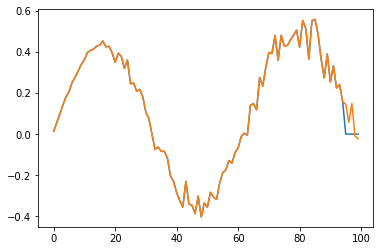

In [17]:
plt.plot(train_data[0,0,:].cpu())
plt.plot(train_data[0,1,:].cpu())

In [18]:
model = TransAm().to(device)

criterion = nn.MSELoss()
lr = 0.005 
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

best_val_loss = float("inf")
epochs = 100 # The number of epochs
best_model = None

In [19]:
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)
    
    
    if(epoch % 10 is 0):
        val_loss = plot_and_loss(model, val_data,epoch)
        predict_future(model, val_data,200)
    else:
        val_loss = evaluate(model, val_data)
        
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    #if val_loss < best_val_loss:
    #    best_val_loss = val_loss
    #    best_model = model

    scheduler.step() 

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   1 |    53/  269 batches | lr 0.005000 | 15.03 ms | loss 6.05257 | ppl   425.20
| epoch   1 |   106/  269 batches | lr 0.005000 |  7.47 ms | loss 0.09276 | ppl     1.10
| epoch   1 |   159/  269 batches | lr 0.005000 |  7.34 ms | loss 0.04333 | ppl     1.04
| epoch   1 |   212/  269 batches | lr 0.005000 |  7.45 ms | loss 0.02570 | ppl     1.03
| epoch   1 |   265/  269 batches | lr 0.005000 |  7.63 ms | loss 0.02294 | ppl     1.02
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  2.56s | valid loss 0.04575 | valid ppl     1.05
-----------------------------------------------------------------------------------------
| epoch   2 |    53/  269 batches | lr 0.004802 |  8.58 ms | loss 0.01866 | ppl     1.02
| epoch   2 |   106/  269 batches | lr 0.004802 |  7.45 ms | loss 0.01336 | ppl     1.01
| epoch   2 |   159/  269 batches | lr 0.004802 |  7.28 ms | loss 0.02526 | ppl     1.03
| epoch   2 |   212/  269 batche

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  11 |    53/  269 batches | lr 0.004004 |  8.17 ms | loss 0.00247 | ppl     1.00
| epoch  11 |   106/  269 batches | lr 0.004004 |  7.80 ms | loss 0.00212 | ppl     1.00
| epoch  11 |   159/  269 batches | lr 0.004004 |  7.45 ms | loss 0.00241 | ppl     1.00
| epoch  11 |   212/  269 batches | lr 0.004004 |  7.29 ms | loss 0.00249 | ppl     1.00
| epoch  11 |   265/  269 batches | lr 0.004004 |  7.55 ms | loss 0.00178 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  11 | time:  2.21s | valid loss 0.00564 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  12 |    53/  269 batches | lr 0.003924 |  8.17 ms | loss 0.00209 | ppl     1.00
| epoch  12 |   106/  269 batches | lr 0.003924 |  7.81 ms | loss 0.00216 | ppl     1.00
| epoch  12 |   159/  269 batches | lr 0.003924 |  7.26 ms | loss 0.00243 | ppl     1.00
| epoch  12 |   212/  269 batche

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  21 |    53/  269 batches | lr 0.003271 |  8.08 ms | loss 0.00149 | ppl     1.00
| epoch  21 |   106/  269 batches | lr 0.003271 |  8.10 ms | loss 0.00138 | ppl     1.00
| epoch  21 |   159/  269 batches | lr 0.003271 |  7.19 ms | loss 0.00149 | ppl     1.00
| epoch  21 |   212/  269 batches | lr 0.003271 |  7.26 ms | loss 0.00164 | ppl     1.00
| epoch  21 |   265/  269 batches | lr 0.003271 |  7.62 ms | loss 0.00155 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  21 | time:  2.21s | valid loss 0.00297 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  22 |    53/  269 batches | lr 0.003206 |  7.51 ms | loss 0.00183 | ppl     1.00
| epoch  22 |   106/  269 batches | lr 0.003206 |  7.94 ms | loss 0.00230 | ppl     1.00
| epoch  22 |   159/  269 batches | lr 0.003206 |  7.19 ms | loss 0.00212 | ppl     1.00
| epoch  22 |   212/  269 batche

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  31 |    53/  269 batches | lr 0.002673 |  9.82 ms | loss 0.00103 | ppl     1.00
| epoch  31 |   106/  269 batches | lr 0.002673 |  9.00 ms | loss 0.00100 | ppl     1.00
| epoch  31 |   159/  269 batches | lr 0.002673 |  8.83 ms | loss 0.00102 | ppl     1.00
| epoch  31 |   212/  269 batches | lr 0.002673 |  8.33 ms | loss 0.00088 | ppl     1.00
| epoch  31 |   265/  269 batches | lr 0.002673 |  8.90 ms | loss 0.00082 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  31 | time:  2.58s | valid loss 0.00135 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  32 |    53/  269 batches | lr 0.002619 |  7.85 ms | loss 0.00111 | ppl     1.00
| epoch  32 |   106/  269 batches | lr 0.002619 |  7.23 ms | loss 0.00113 | ppl     1.00
| epoch  32 |   159/  269 batches | lr 0.002619 |  7.64 ms | loss 0.00111 | ppl     1.00
| epoch  32 |   212/  269 batche

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  41 |    53/  269 batches | lr 0.002184 |  8.15 ms | loss 0.00080 | ppl     1.00
| epoch  41 |   106/  269 batches | lr 0.002184 |  7.25 ms | loss 0.00083 | ppl     1.00
| epoch  41 |   159/  269 batches | lr 0.002184 |  8.07 ms | loss 0.00110 | ppl     1.00
| epoch  41 |   212/  269 batches | lr 0.002184 |  8.27 ms | loss 0.00111 | ppl     1.00
| epoch  41 |   265/  269 batches | lr 0.002184 |  7.21 ms | loss 0.00090 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  41 | time:  2.26s | valid loss 0.00080 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  42 |    53/  269 batches | lr 0.002140 |  7.49 ms | loss 0.00089 | ppl     1.00
| epoch  42 |   106/  269 batches | lr 0.002140 |  7.10 ms | loss 0.00080 | ppl     1.00
| epoch  42 |   159/  269 batches | lr 0.002140 |  7.16 ms | loss 0.00079 | ppl     1.00
| epoch  42 |   212/  269 batche

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  51 |    53/  269 batches | lr 0.001784 |  8.94 ms | loss 0.00067 | ppl     1.00
| epoch  51 |   106/  269 batches | lr 0.001784 |  7.95 ms | loss 0.00063 | ppl     1.00
| epoch  51 |   159/  269 batches | lr 0.001784 |  8.80 ms | loss 0.00063 | ppl     1.00
| epoch  51 |   212/  269 batches | lr 0.001784 |  8.97 ms | loss 0.00070 | ppl     1.00
| epoch  51 |   265/  269 batches | lr 0.001784 |  7.62 ms | loss 0.00068 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  51 | time:  2.44s | valid loss 0.00067 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  52 |    53/  269 batches | lr 0.001749 |  7.54 ms | loss 0.00069 | ppl     1.00
| epoch  52 |   106/  269 batches | lr 0.001749 |  7.23 ms | loss 0.00059 | ppl     1.00
| epoch  52 |   159/  269 batches | lr 0.001749 |  7.23 ms | loss 0.00065 | ppl     1.00
| epoch  52 |   212/  269 batche

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  61 |    53/  269 batches | lr 0.001458 |  8.03 ms | loss 0.00071 | ppl     1.00
| epoch  61 |   106/  269 batches | lr 0.001458 |  7.65 ms | loss 0.00060 | ppl     1.00
| epoch  61 |   159/  269 batches | lr 0.001458 |  9.09 ms | loss 0.00059 | ppl     1.00
| epoch  61 |   212/  269 batches | lr 0.001458 |  7.70 ms | loss 0.00059 | ppl     1.00
| epoch  61 |   265/  269 batches | lr 0.001458 |  7.36 ms | loss 0.00055 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  61 | time:  2.31s | valid loss 0.00081 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  62 |    53/  269 batches | lr 0.001429 |  7.43 ms | loss 0.00067 | ppl     1.00
| epoch  62 |   106/  269 batches | lr 0.001429 |  7.83 ms | loss 0.00059 | ppl     1.00
| epoch  62 |   159/  269 batches | lr 0.001429 |  9.15 ms | loss 0.00062 | ppl     1.00
| epoch  62 |   212/  269 batche

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  71 |    53/  269 batches | lr 0.001191 |  8.19 ms | loss 0.00057 | ppl     1.00
| epoch  71 |   106/  269 batches | lr 0.001191 |  7.41 ms | loss 0.00053 | ppl     1.00
| epoch  71 |   159/  269 batches | lr 0.001191 |  7.16 ms | loss 0.00056 | ppl     1.00
| epoch  71 |   212/  269 batches | lr 0.001191 |  7.21 ms | loss 0.00054 | ppl     1.00
| epoch  71 |   265/  269 batches | lr 0.001191 |  7.27 ms | loss 0.00050 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  71 | time:  2.16s | valid loss 0.00096 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  72 |    53/  269 batches | lr 0.001167 |  7.58 ms | loss 0.00052 | ppl     1.00
| epoch  72 |   106/  269 batches | lr 0.001167 |  7.27 ms | loss 0.00049 | ppl     1.00
| epoch  72 |   159/  269 batches | lr 0.001167 |  7.27 ms | loss 0.00058 | ppl     1.00
| epoch  72 |   212/  269 batche

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  81 |    53/  269 batches | lr 0.000973 |  9.63 ms | loss 0.00053 | ppl     1.00
| epoch  81 |   106/  269 batches | lr 0.000973 |  8.76 ms | loss 0.00046 | ppl     1.00
| epoch  81 |   159/  269 batches | lr 0.000973 |  8.03 ms | loss 0.00050 | ppl     1.00
| epoch  81 |   212/  269 batches | lr 0.000973 |  7.12 ms | loss 0.00063 | ppl     1.00
| epoch  81 |   265/  269 batches | lr 0.000973 |  7.08 ms | loss 0.00060 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  81 | time:  2.34s | valid loss 0.00087 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  82 |    53/  269 batches | lr 0.000954 |  7.85 ms | loss 0.00051 | ppl     1.00
| epoch  82 |   106/  269 batches | lr 0.000954 |  8.48 ms | loss 0.00047 | ppl     1.00
| epoch  82 |   159/  269 batches | lr 0.000954 |  7.77 ms | loss 0.00049 | ppl     1.00
| epoch  82 |   212/  269 batche

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  91 |    53/  269 batches | lr 0.000795 |  9.00 ms | loss 0.00048 | ppl     1.00
| epoch  91 |   106/  269 batches | lr 0.000795 |  7.34 ms | loss 0.00043 | ppl     1.00
| epoch  91 |   159/  269 batches | lr 0.000795 |  7.25 ms | loss 0.00044 | ppl     1.00
| epoch  91 |   212/  269 batches | lr 0.000795 |  8.66 ms | loss 0.00041 | ppl     1.00
| epoch  91 |   265/  269 batches | lr 0.000795 |  7.19 ms | loss 0.00045 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  91 | time:  2.29s | valid loss 0.00085 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  92 |    53/  269 batches | lr 0.000779 |  7.52 ms | loss 0.00050 | ppl     1.00
| epoch  92 |   106/  269 batches | lr 0.000779 |  7.23 ms | loss 0.00044 | ppl     1.00
| epoch  92 |   159/  269 batches | lr 0.000779 |  8.03 ms | loss 0.00046 | ppl     1.00
| epoch  92 |   212/  269 batche

In [21]:
ls graph

transformer-epoch100.png  transformer-epoch40.png  transformer-epoch80.png
transformer-epoch10.png   transformer-epoch50.png  transformer-epoch90.png
transformer-epoch20.png   transformer-epoch60.png  transformer-future200.png
transformer-epoch30.png   transformer-epoch70.png


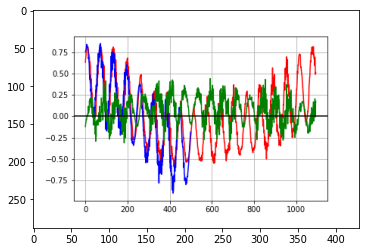

In [35]:
import matplotlib.pyplot as plt
steps = 10
img = plt.imread('graph/transformer-epoch%d.png'%steps)
plt.imshow(img)


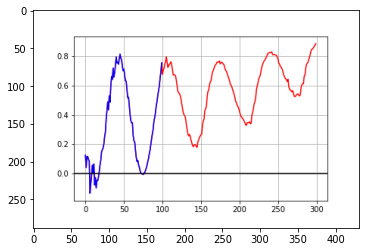

In [38]:
img = plt.imread('graph/transformer-future200.png')
plt.imshow(img)